In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install "numpy<2.0.0"

# Downstream: DGEA and GSEA
Differential gene expression (DGE) analysis is a crucial tool for identifying genes that are significantly over or underexpressed between different conditions (e.g., healthy vs. disease) within specific cell types.

While many tools exist for DGE analysis, recent studies suggest that pseudobulk methods (which aggregate cell-type-specific expression values per individual) perform particularly well for single-cell data, helping to avoid issues like pseudoreplication and inflated false discovery rates.

In this notebook, we'll show how to perform both, primarily using the packages `decoupleR` and `pybiomart` for gene symbol conversion. If you haven't yet installed it, you can do so with


In [2]:
%%capture
!pip install scanpy decoupler pybiomart pydeseq2 skmisc

In [3]:
!pip install scanpy

In [4]:
!pip install decoupler

In [5]:
import scanpy as sc
import pandas as pd
import numpy as np
import decoupler as dc
import matplotlib.pyplot as plt

In [6]:
!pip install pydeseq2

  Using cached numpy-2.4.1-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (6.6 kB)
Using cached numpy-2.4.1-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.4.1 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.4.1 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.4.1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.4.1 which is incompatible.
dat

In [7]:
# for differential expression analysis
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats
import adjustText

sc.settings.njobs = 1

## Understanding Pseudobulk Analysis
When working with single-cell data across multiple conditions, performing differential expression at the single-cell level can lead to inflated p-values because each cell is treated as an independent sample.

However, cells from the same sample are not truly independent since they share the same environment. Additionally, uneven cell numbers between samples can bias results.

The pseudobulk approach addresses these issues by:
1. Aggregating cells from the same sample and cell type
2. Working with raw counts rather than normalized data
3. Requiring multiple biological replicates per condition
4. Accounting for sample-level variation

## Generate Pseudobulks

We'll now create pseudobulk profiles by summing counts across cells from the same sample and cell type. This helps recover lowly expressed genes that might be affected by dropout in single-cell analysis and provides a more robust foundation for differential expression testing.

In [8]:
adata_raw = sc.datasets.ebi_expression_atlas("E-MTAB-9221", filter_boring=True)
adata_raw

AnnData object with n_obs × n_vars = 6807 × 20522
    obs: 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[age]', 'Sample Characteristic[individual]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[clinical history]', 'Factor Value[disease]', 'Factor Value Ontology Term[disease]', 'Factor Value[clinical history]', 'Factor Value[sampling time point]', 'Factor Value[inferred cell type - ontology labels]', 'Factor Value Ontology Term[inferred cell type - ontology labels]'

In [9]:
# Rename meta-data
columns = [
    "Sample Characteristic[sex]",
    "Sample Characteristic[individual]",
    "Sample Characteristic[disease]",
    "Factor Value[inferred cell type - ontology labels]",
]

adata_raw.obs = adata_raw.obs[columns]
adata_raw.obs.columns = ["sex", "individual", "disease", "cell_type"]

In [10]:
adata_raw.obs

,sex,individual,disease,cell_type
SAMEA6979313-AAACCCAAGACTCAAA,female,Control #1,normal,NaN
SAMEA6979313-AAAGAACCACCTGCTT,female,Control #1,normal,T cell
SAMEA6979313-AAAGGATGTCCCTCAT,female,Control #1,normal,monocyte
SAMEA6979313-AAAGGGTGTCCCTCAT,female,Control #1,normal,NaN
SAMEA6979313-AAAGGTTGTCCCTCAT,female,Control #1,normal,NaN
...,...,...,...,...
SAMEA6979322-TTTCCTCTCAACCTCC,not available,SARS-CoV2 pos Severe #3,COVID-19,NaN
SAMEA6979322-TTTCGATAGATTAGAC,not available,SARS-CoV2 pos Severe #3,COVID-19,NaN
SAMEA6979322-TTTGATCCAATAGTGA,not available,SARS-CoV2 pos Severe #3,COVID-19,NaN
SAMEA6979322-TTTGGTTAGAATTGTG,not available,SARS-CoV2 pos Severe #3,COVID-19,T cell


In [11]:
adata_raw

AnnData object with n_obs × n_vars = 6807 × 20522
    obs: 'sex', 'individual', 'disease', 'cell_type'

## Preprocessing
### Aligning gene identifiers
One common challenge in bioinformatics is dealing with different gene identifier systems. We'll use ENSEBML IDs for the following steps since these are usually more precise than gene symbols.

In [12]:
!pip install pybiomart

In [13]:
annot = sc.queries.biomart_annotations(
    "hsapiens", ["ensembl_gene_id", "external_gene_name"], use_cache=False
).set_index("ensembl_gene_id")
annot.head()

,external_gene_name
ensembl_gene_id,
ENSG00000210049,MT-TF
ENSG00000211459,MT-RNR1
ENSG00000210077,MT-TV
ENSG00000210082,MT-RNR2
ENSG00000209082,MT-TL1


In [14]:
# Filter genes not in annotation
adata = adata_raw[:, adata_raw.var.index.intersection(annot.index.values)]

adata

View of AnnData object with n_obs × n_vars = 6807 × 20445
    obs: 'sex', 'individual', 'disease', 'cell_type'

In [15]:
# Assign gene symbols
adata.var["gene_symbol"] = [
    annot.loc[ensembl_id, "external_gene_name"] for ensembl_id in adata.var.index
]
adata.var = (
    adata.var.reset_index()
    .rename(columns={"index": "ensembl_gene_id"})
    .set_index("gene_symbol")
)

/tmp/ipykernel_460/213397040.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["gene_symbol"] = [


In [16]:
# Remove genes with no gene symbol
adata = adata[:, ~pd.isnull(adata.var.index)]

In [17]:
# Remove duplicate genes
adata.var_names_make_unique()

adata

/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6807 × 19131
    obs: 'sex', 'individual', 'disease', 'cell_type'
    var: 'ensembl_gene_id'

In [18]:
# let's remove cells without an annotated celltype for easier downstream analysis
adata = adata[~adata.obs["cell_type"].isnull()]

adata

View of AnnData object with n_obs × n_vars = 4903 × 19131
    obs: 'sex', 'individual', 'disease', 'cell_type'
    var: 'ensembl_gene_id'

We will need the raw counts for subsequent pseudo-bulk analysis, so let's save them in another `AnnData` layer.

In [19]:
adata.X = np.round(adata.X)
adata.layers["counts"] = adata.X.copy()
adata

/tmp/ipykernel_460/2894375519.py:1: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata.X = np.round(adata.X)
/tmp/ipykernel_460/2894375519.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


AnnData object with n_obs × n_vars = 4903 × 19131
    obs: 'sex', 'individual', 'disease', 'cell_type'
    var: 'ensembl_gene_id'
    layers: 'counts'

In [20]:
adata.layers

Layers with keys: counts

In [21]:
# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers["normalized"] = adata.X.copy()

In [22]:
adata.layers

Layers with keys: counts, normalized

In [23]:
# Check that elements are integers by comparing rounded values to originals
counts_matrix = adata.layers["counts"][:1, :10][adata.layers["counts"][:1, :10]>0]
X_matrix = adata.X[:1, :10][adata.X[:1, :10]>0]
assert np.round(counts_matrix) == counts_matrix
assert not np.round(X_matrix) == X_matrix

In [24]:
!pip install scikit-misc

In [25]:
# Identify highly variable genes
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=2000, batch_key="individual"
)

/usr/local/lib/python3.11/dist-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


In [26]:
# Scale the data
sc.pp.scale(adata, max_value=10)

/usr/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [27]:
# Generate PCA features
sc.tl.pca(adata, svd_solver="arpack", use_highly_variable=True)

In [28]:
# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7b0a789d76a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [29]:
# Generate UMAP features
sc.tl.umap(adata)

In [30]:
adata.obs

,sex,individual,disease,cell_type
SAMEA6979313-AAAGAACCACCTGCTT,female,Control #1,normal,T cell
SAMEA6979313-AAAGGATGTCCCTCAT,female,Control #1,normal,monocyte
SAMEA6979313-AACAGGGAGATCACTC,female,Control #1,normal,T cell
SAMEA6979313-AACCAACGTGTGAGCA,female,Control #1,normal,T cell
SAMEA6979313-AACCATGAGCAGCGAT,female,Control #1,normal,monocyte
...,...,...,...,...
SAMEA6979322-TTCACGCTCAATGTCG,not available,SARS-CoV2 pos Severe #3,COVID-19,T cell
SAMEA6979322-TTCTAGTAGAATGTTG,not available,SARS-CoV2 pos Severe #3,COVID-19,T cell
SAMEA6979322-TTGGTTTCACTGATTG,not available,SARS-CoV2 pos Severe #3,COVID-19,T cell
SAMEA6979322-TTGTTTGCACACACTA,not available,SARS-CoV2 pos Severe #3,COVID-19,T cell


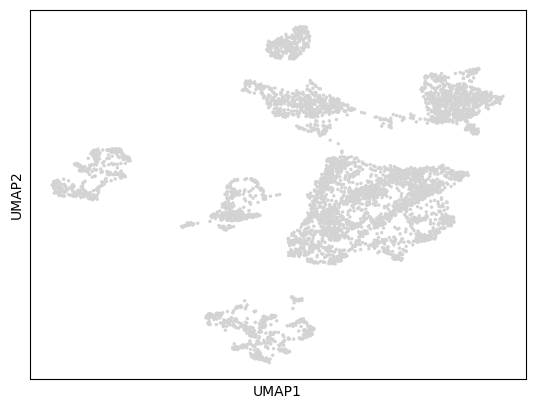

In [31]:
# Visualize
sc.pl.umap(adata)

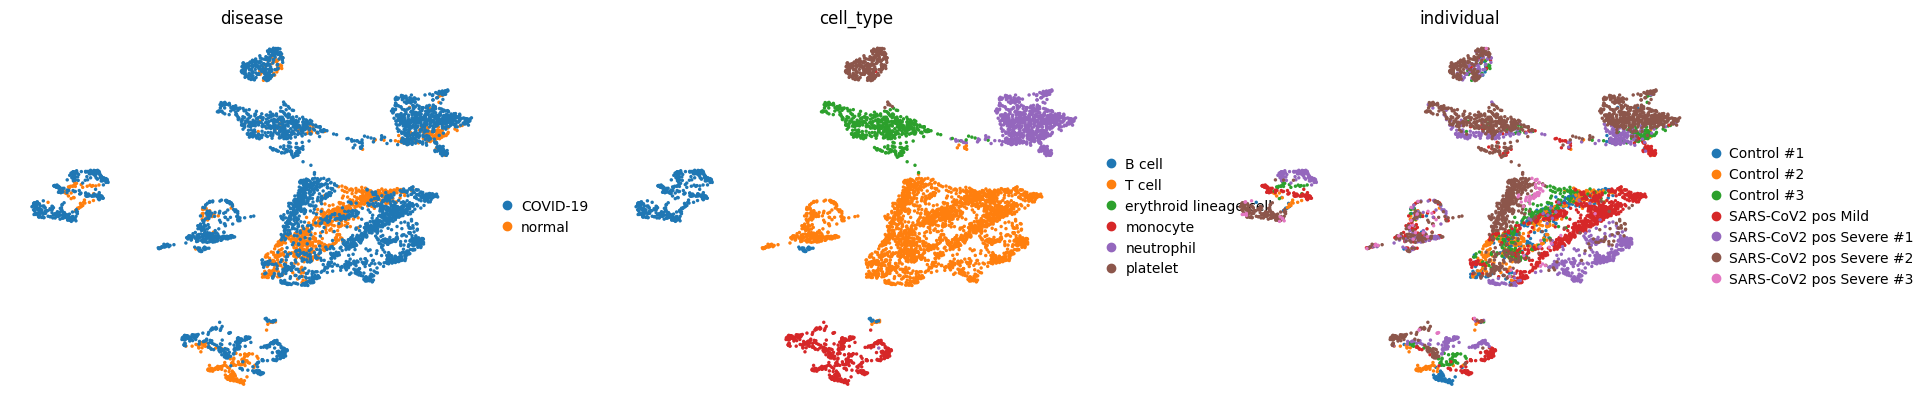

In [32]:
# Visualize by color
sc.pl.umap(adata, color=["disease", "cell_type", "individual"], frameon=False)

We can see that we have fairly good mixing of disease conditions (COVID-19/normal) and individuals in our data while the cell types are mostly separated.

## Assess the quality of our pseudo-bulks
When generating pseudobulk profiles, we need to ensure that each aggregated sample has sufficient data for reliable analysis.

Samples with too few cells or low total counts may introduce noise and bias into downstream analyses. While the specific thresholds depend on the dataset, requiring at least 10 cells and 1000 total counts per sample helps maintain statistical power while filtering out potentially unreliable measurements.

In [33]:
pdata = dc.pp.pseudobulk(
    adata,
    sample_col="individual",  # so we have multiple samples
    groups_col="cell_type",  # defines contrasts
    layer="counts",  # use normalized counts
    mode="sum",  # sum up counts for each group
)

In [34]:
pdata.obs

,individual,cell_type,sex,disease,psbulk_cells,psbulk_counts
Control #1_B cell,Control #1,B cell,female,normal,10.0,79450.0
Control #2_B cell,Control #2,B cell,female,normal,17.0,138514.0
Control #3_B cell,Control #3,B cell,female,normal,20.0,151160.0
SARS-CoV2 pos Mild_B cell,SARS-CoV2 pos Mild,B cell,female,COVID-19,85.0,559561.0
SARS-CoV2 pos Severe #1_B cell,SARS-CoV2 pos Severe #1,B cell,male,COVID-19,97.0,705894.0
SARS-CoV2 pos Severe #2_B cell,SARS-CoV2 pos Severe #2,B cell,female,COVID-19,142.0,924986.0
SARS-CoV2 pos Severe #3_B cell,SARS-CoV2 pos Severe #3,B cell,not available,COVID-19,14.0,118323.0
Control #1_T cell,Control #1,T cell,female,normal,256.0,2221627.0
Control #2_T cell,Control #2,T cell,female,normal,276.0,2154437.0
Control #3_T cell,Control #3,T cell,female,normal,216.0,1711189.0


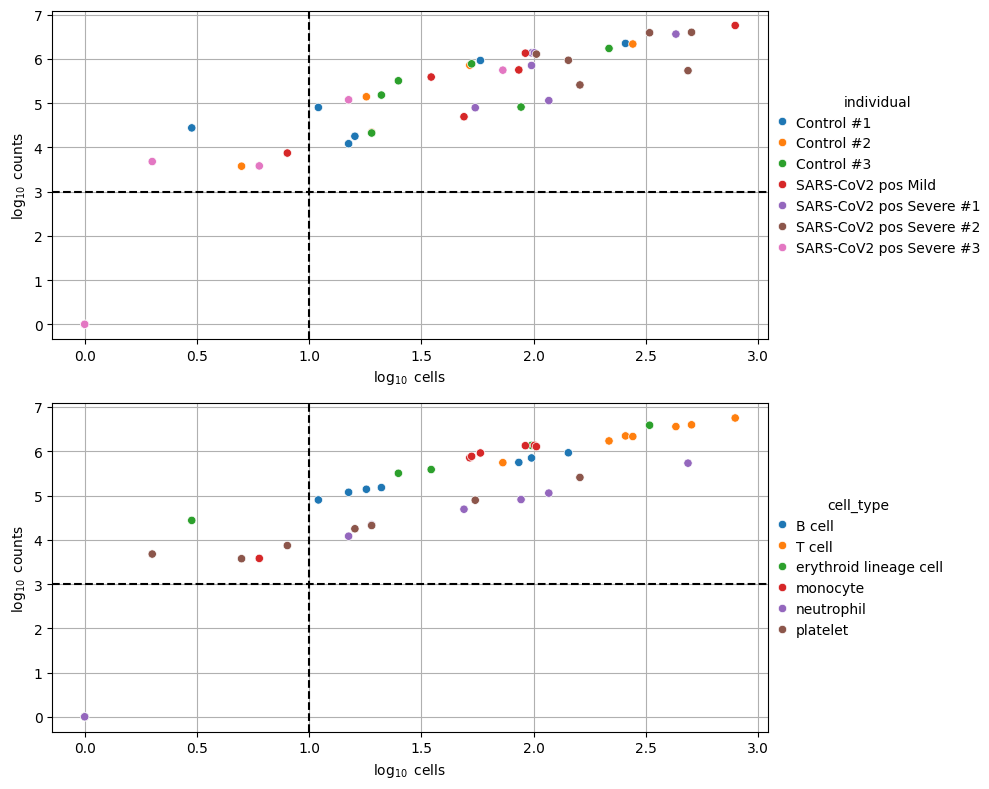

In [36]:
dc.pl.filter_samples(
    adata=pdata,
    groupby=["individual", "cell_type"],
    min_cells=10,
    min_counts=1000,
    figsize=(10, 8),
)

We'll filter out celltype-individual pseudo-bulks that don't contain at least 10 cells and 1000 total counts.

In [37]:
dc.pp.filter_samples(pdata, min_cells=10, min_counts=1000)

In [38]:
pdata

AnnData object with n_obs × n_vars = 34 × 19131
    obs: 'individual', 'cell_type', 'sex', 'disease', 'psbulk_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    layers: 'psbulk_props'

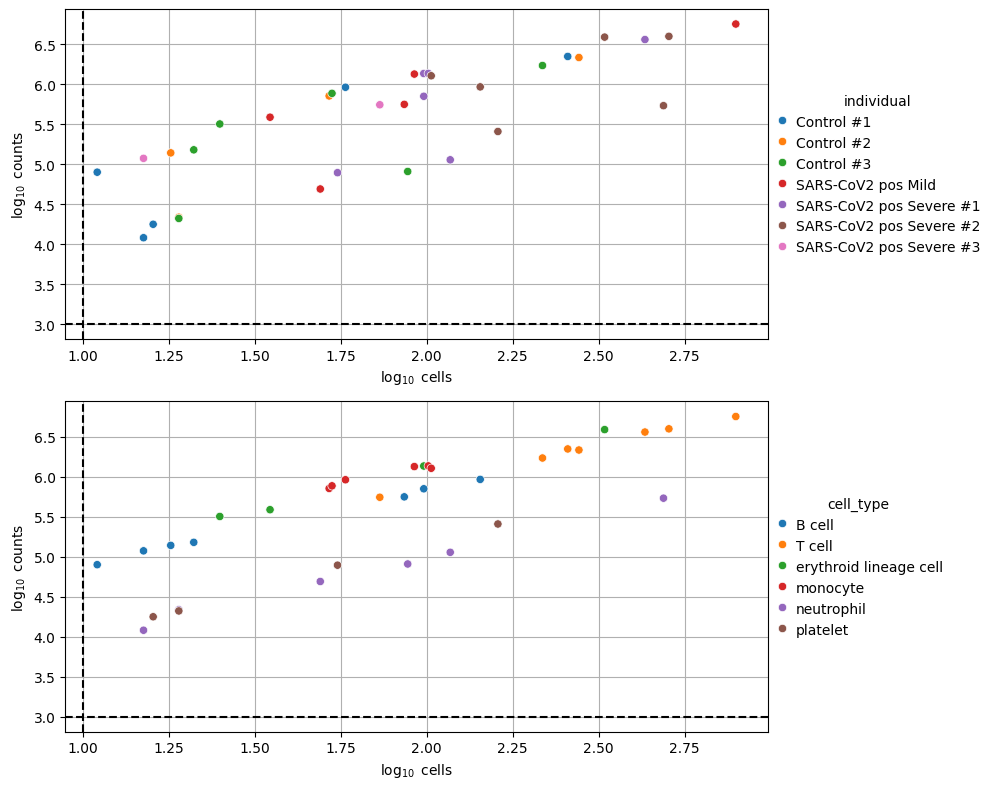

In [39]:
dc.pl.filter_samples(
    adata=pdata,
    groupby=["individual", "cell_type"],
    min_cells=10,
    min_counts=1000,
    figsize=(10, 8),
)

We can see that we now end up with 34 observations which represent the filtered `individual_celltype` combinations.

In [40]:
pdata

AnnData object with n_obs × n_vars = 34 × 19131
    obs: 'individual', 'cell_type', 'sex', 'disease', 'psbulk_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    layers: 'psbulk_props'

In [41]:
pdata.to_df().head()

gene_symbol,TSPAN6,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,...,F8A1,CTAGE4-1,H2AC18,H2AC19,ARHGAP11A-SCG5,PPIAL4C,RPSA2,COX8BP,CTAGE8-1,XNDC1N-ZNF705EP-ALG1L9P
Control #1_B cell,0.0,4.0,0.0,0.0,2.0,7.0,0.0,3.0,1.0,3.0,...,0.0,0.0,3.0,3.0,0.0,0.0,18.0,0.0,0.0,0.0
Control #2_B cell,0.0,12.0,2.0,0.0,1.0,12.0,0.0,4.0,2.0,8.0,...,2.0,0.0,2.0,2.0,0.0,0.0,19.0,0.0,0.0,0.0
Control #3_B cell,0.0,5.0,0.0,0.0,2.0,5.0,0.0,3.0,0.0,5.0,...,5.0,0.0,4.0,4.0,0.0,0.0,23.0,0.0,0.0,0.0
SARS-CoV2 pos Mild_B cell,0.0,34.0,8.0,1.0,12.0,44.0,2.0,16.0,12.0,18.0,...,7.0,0.0,48.0,48.0,0.0,0.0,220.0,0.0,0.0,0.0
SARS-CoV2 pos Severe #1_B cell,0.0,47.0,4.0,3.0,35.0,45.0,2.0,13.0,10.0,21.0,...,13.0,0.0,25.0,25.0,1.0,0.0,197.0,0.0,0.0,0.0


In [42]:
# save counts and norm_counts to not overwrite the "counts" with normalized counts later on
pdata.layers["counts"] = pdata.X.copy()
pdata.layers["norm_counts"] = pdata.X.copy()

In [43]:
dc.pp.swap_layer(adata=pdata, key="counts", inplace=True)

In [44]:
pdata

AnnData object with n_obs × n_vars = 34 × 19131
    obs: 'individual', 'cell_type', 'sex', 'disease', 'psbulk_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    layers: 'psbulk_props', 'counts', 'norm_counts', 'X'

In [45]:
# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4, layer="norm_counts")
sc.pp.log1p(pdata, layer="norm_counts")
sc.pp.scale(pdata, max_value=10, layer="norm_counts")
sc.tl.pca(pdata, layer="norm_counts")

In [46]:
pdata.X = pdata.layers["norm_counts"]

In [47]:
pdata

AnnData object with n_obs × n_vars = 34 × 19131
    obs: 'individual', 'cell_type', 'sex', 'disease', 'psbulk_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts', 'norm_counts', 'X'

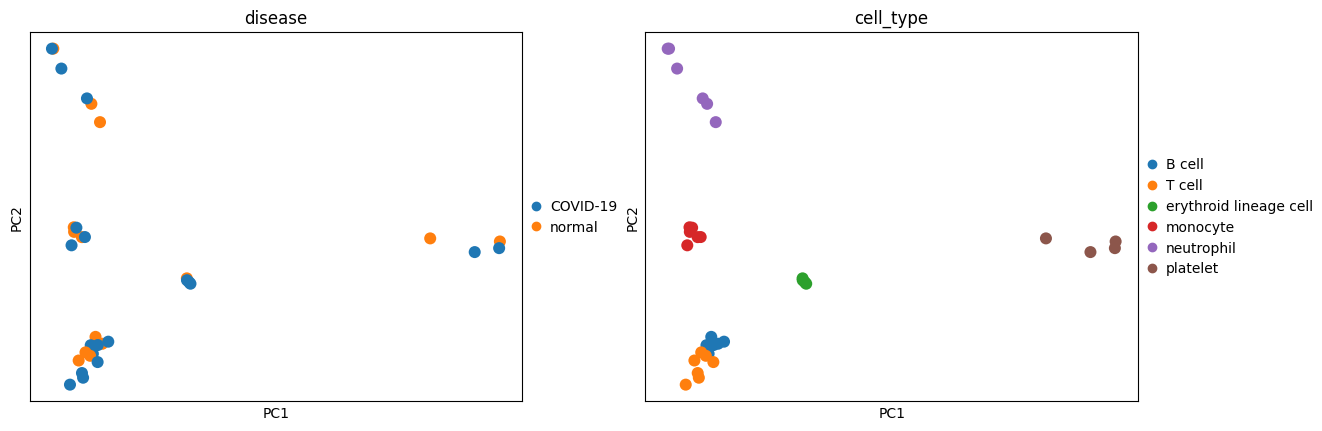

In [48]:
sc.pl.pca(pdata, color=["disease", "cell_type"], size=300)

We see in the PCA that our data seems to cluster well by celltype whereas conditions are mixed. In the plot below we see that PC1 and PC2 explain the majority of the variance which explains why the above plots are separated so well.

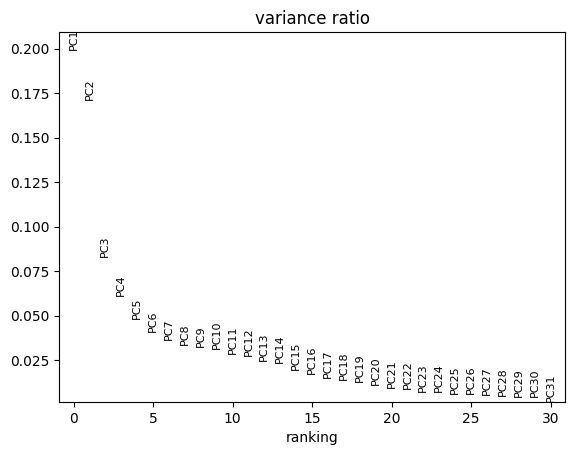

In [49]:
sc.pl.pca_variance_ratio(pdata)

## Denoising the pseudo-bulks
After filtering low-quality samples, we need to ensure that the genes we analyze are reliably expressed. Since different cell types express distinct sets of genes, we perform this filtering separately for each cell type.

In the next steps, we'll focus on T cells.

In [50]:
pdata.obs.head()

,individual,cell_type,sex,disease,psbulk_cells,psbulk_counts
Control #1_B cell,Control #1,B cell,female,normal,10.0,79450.0
Control #2_B cell,Control #2,B cell,female,normal,17.0,138514.0
Control #3_B cell,Control #3,B cell,female,normal,20.0,151160.0
SARS-CoV2 pos Mild_B cell,SARS-CoV2 pos Mild,B cell,female,COVID-19,85.0,559561.0
SARS-CoV2 pos Severe #1_B cell,SARS-CoV2 pos Severe #1,B cell,male,COVID-19,97.0,705894.0


In [51]:
tcells = pdata[pdata.obs["cell_type"] == "T cell"].copy()
tcells.X = tcells.layers["counts"]
tcells

AnnData object with n_obs × n_vars = 7 × 19131
    obs: 'individual', 'cell_type', 'sex', 'disease', 'psbulk_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'log1p', 'pca', 'disease_colors', 'cell_type_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts', 'norm_counts', 'X'

We expect a bimodal distribution in these genes with one cluster of genes being expressed very little and only by very few samples. We will adjust the `min_count` and `min_total_count` parameters to filter these out.

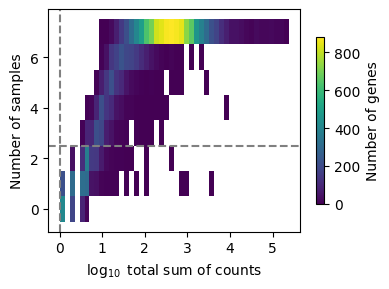

In [52]:
dc.pl.filter_by_expr(
    adata=tcells,
    group="disease",
    min_count=1,
    min_total_count=1,
    large_n=10,
    min_prop=0.7,
)

Once we've found sufficiently good values, we'll use these to subset the genes in the T cell `AnnData` object.

In [53]:
# genes = dc.filter_by_expr(tcells, group="disease", min_count=10, min_total_count=15)
dc.pp.filter_by_expr(
    adata=tcells,
    group="disease",
    min_count=10,
    min_total_count=15,
    large_n=10,
    min_prop=0.7,
)

In [54]:
tcells

AnnData object with n_obs × n_vars = 7 × 10425
    obs: 'individual', 'cell_type', 'sex', 'disease', 'psbulk_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'log1p', 'pca', 'disease_colors', 'cell_type_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts', 'norm_counts', 'X'

## Differential expression analysis of the pseudo-bulks using `pydeseq2`
In this dataset, a natural contrast to explore is how the gene expression of T cells differes between healthy patients and patienst suffering from COVID-19. To do so, we'll use PyDESeq2, a Python implementation of the popular R packages.

More details can be found in the [PyDESeq2 documentation](https://pydeseq2.readthedocs.io/en/latest/)

In [55]:
tcells.X = tcells.layers["counts"]

In [56]:
inference = DefaultInference(n_cpus=1)

dds = DeseqDataSet(
    adata=tcells,
    design_factors="disease",
    ref_level=["normal", "COVID-19"],
    refit_cooks=True,
    inference=inference,
)

/tmp/ipykernel_460/3161313654.py:3: DeprecationWarning: ref_level is deprecated and no longer has any effect. It will beremoved in a future release.
  dds = DeseqDataSet(
/tmp/ipykernel_460/3161313654.py:3: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(


In [57]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 41.81 seconds.

Fitting dispersion trend curve...
... done in 0.80 seconds.

Fitting MAP dispersions...
... done in 22.82 seconds.

Fitting LFCs...
... done in 5.14 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



In [58]:
stat_res = DeseqStats(
    dds,
    contrast=["disease", "COVID-19", "normal"],
    inference=inference,
)

In [59]:
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: disease COVID-19 vs normal
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                             
DPM1         153.973152        0.135588  0.233943  0.579578  0.562199   
SCYL3         20.672505        0.191151  0.426763  0.447908  0.654219   
FGR           26.627576       -0.864156  0.363057 -2.380224  0.017302   
CFH          160.148145       -0.441831  0.230875 -1.913724  0.055655   
FUCA2         13.066746        0.347594  0.509803  0.681820  0.495353   
...                 ...             ...       ...       ...       ...   
PRRC2B       140.499291       -0.039601  0.236889 -0.167170  0.867236   
F8A1          42.814238       -0.314058  0.357009 -0.879691  0.379027   
H2AC18        95.782893        0.909307  0.394378  2.305672  0.021129   
H2AC19        97.686977        0.811904  0.403139  2.013959  0.044014   
RPSA2        737.232682        1.856871  0.608042  3.053854

... done in 2.02 seconds.



In [60]:
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
DPM1,153.973152,0.135588,0.233943,0.579578,0.562199,0.895105
SCYL3,20.672505,0.191151,0.426763,0.447908,0.654219,0.924652
FGR,26.627576,-0.864156,0.363057,-2.380224,0.017302,0.264986
CFH,160.148145,-0.441831,0.230875,-1.913724,0.055655,0.441585
FUCA2,13.066746,0.347594,0.509803,0.681820,0.495353,0.870776
...,...,...,...,...,...,...
PRRC2B,140.499291,-0.039601,0.236889,-0.167170,0.867236,0.973653
F8A1,42.814238,-0.314058,0.357009,-0.879691,0.379027,0.820778
H2AC18,95.782893,0.909307,0.394378,2.305672,0.021129,0.287999


## Visual inspection of differentially expressed genes
Volcano plots visualize differential expression results by plotting statistical significance (-log10 p-value) against effect size (log2 fold change). They help quickly identify genes that show both significant and substantial expression changes between conditions, making them a valuable tool for prioritizing genes for further investigation.

Typically, one adds visual guiding lines at 1.3 for the y-axis (-log10(0.05)) and +/- 1 log2(2) foldchange for the x-axis.

#### Why the adjusted p-value?
When performing differential expression analysis across thousands of genes, we use adjusted p-values (typically Benjamini-Hochberg correction) to control for multiple testing. This is crucial because testing many genes simultaneously increases the chance of false positives - if we used raw p-values and tested 10,000 genes at p < 0.05, we'd expect about 500 false positives by chance alone.

The adjusted p-value (or FDR - False Discovery Rate) helps control this problem by adjusting the significance threshold based on the number of tests performed, giving us more confidence that our findings represent true biological differences rather than statistical artifacts.

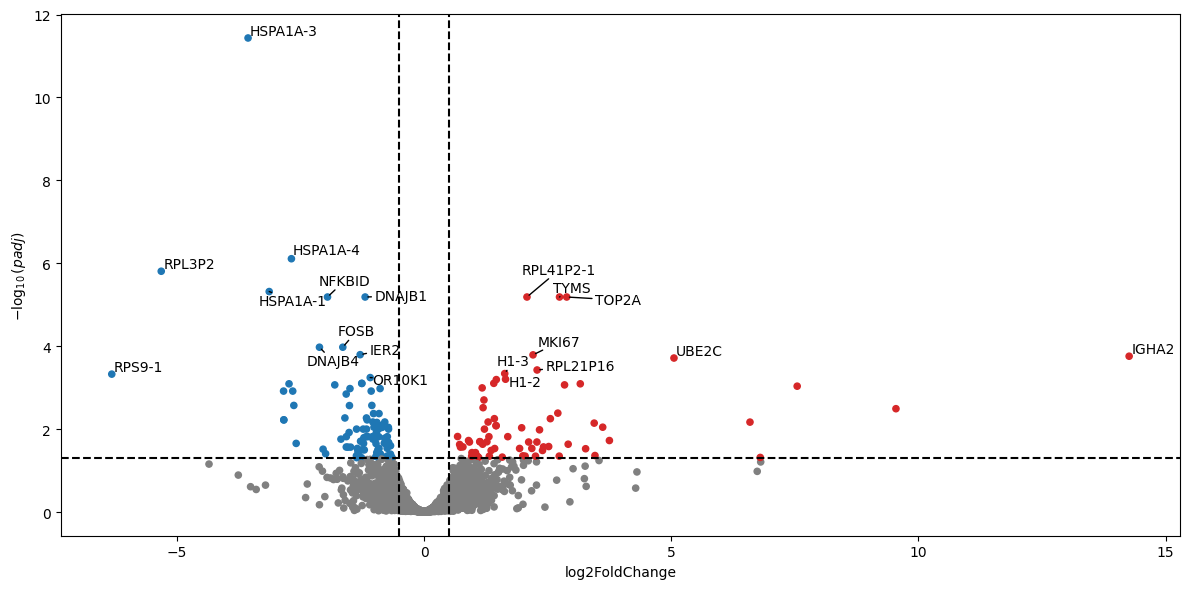

In [61]:
dc.pl.volcano(results_df, x="log2FoldChange", y="padj", top=20, figsize=(12, 6))

## Enrichment with Over Representation Analysis (ORA)

Once we have identified differentially expressed genes, we can interpret their biological significance through enrichment analysis. This helps us understand which pathways or biological processes are altered between conditions. We'll use:

1. Over-Representation Analysis (ORA): Tests whether genes in a pathway appear more frequently than expected by chance in our set of differential genes
2. MSigDB gene sets: A comprehensive collection of annotated gene sets for various biological processes
3. Visualization of enrichment results to identify key pathways

This analysis helps translate our gene-level findings into biological insights about pathway regulation and cellular processes.

In [62]:
collection = "progeny"

if collection == "hallmark":
    hallmark = dc.op.hallmark(organism="human")
    print(hallmark.head())
elif collection == "progeny":
    progeny = dc.op.progeny(organism="human")
    print(progeny.head())

     source   target     weight          padj
0  Androgen  TMPRSS2  11.490631  2.384806e-47
1  Androgen   NKX3-1  10.622551  2.205102e-44
2  Androgen   MBOAT2  10.472733  4.632376e-44
3  Androgen     KLK2  10.176186  1.944410e-40
4  Androgen     SARG  11.386852  2.790210e-40


In [63]:
data = results_df[["stat"]].T.rename(index={"stat": "disease.vs.normal"})
data

gene_symbol,DPM1,SCYL3,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,...,ELP5-1,SAMD1-1,DDX51,DUS4L-BCAP29,C8orf44-SGK3,PRRC2B,F8A1,H2AC18,H2AC19,RPSA2
disease.vs.normal,0.579578,0.447908,-2.380224,-1.913724,0.68182,-1.80571,-0.580162,-2.326315,0.846632,0.2662,...,0.141331,-2.213846,0.478244,2.004254,-1.177628,-0.16717,-0.879691,2.305672,2.013959,3.053854


In [64]:
# Run
tf_acts, tf_padj = dc.mt.ulm(data=data, net=progeny)

# Filter by sign padj
msk = (tf_padj.T < 0.05).iloc[:, 0]
tf_acts = tf_acts.loc[:, msk]

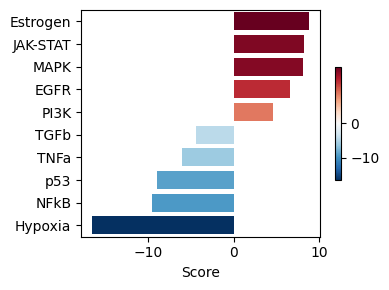

In [65]:
dc.pl.barplot(data=tf_acts, name="disease.vs.normal", figsize=(4, 3))

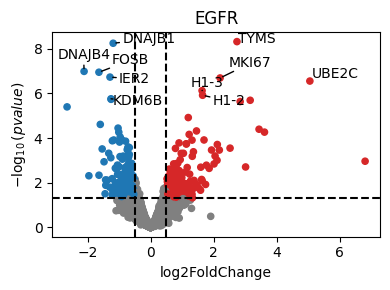

In [66]:
dc.pl.volcano(
    data=results_df,
    x="log2FoldChange",
    y="pvalue",
    net=progeny,
    name="EGFR", # Changed 'ATF3' to a valid pathway name from progeny["source"]
    top=10,
)

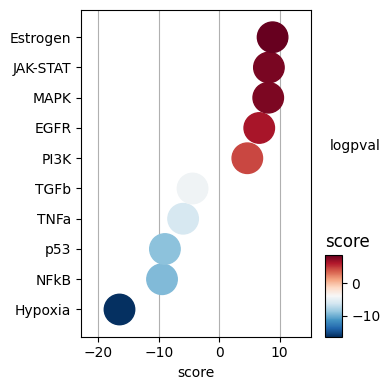

In [67]:
if collection == "progeny":
    df = tf_acts.melt(value_name="score").merge(
    tf_padj.melt(value_name="pvalue")
    .assign(logpval=lambda x: x["pvalue"].clip(2.22e-4, 1))
    .assign(logpval=lambda x: -np.log10(x["logpval"]))
    )
    dc.pl.dotplot(df=df, x="score", y="variable", s="logpval", c="score", scale=1, figsize=(4, 4))
if collection == "hallmark":
    df = tf_acts.melt(value_name="score").merge(
        tf_padj.melt(value_name="pvalue")
        .assign(padj=lambda x: x["pvalue"].clip(2.22e-16, 1))
        .assign(padj=lambda x: np.log10(x["pvalue"]))
    )
    dc.pl.dotplot(df=df, x="score", y="variable", s="padj", c="score", scale=0.25, figsize=(6, 3))